In [9]:
!pip install torchvision matplotlib numpy tensorboard standard-imghdr torchnet scikit-learn opencv-python Levenshtein pycm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 3.9 MB/s eta 0:00:00a 0:00:01


In [2]:
# imports
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data.dataset import Dataset
from PIL import Image, ImageDraw, ImageFont
from sklearn.metrics import accuracy_score

from torch.utils.tensorboard import SummaryWriter

from ImageToStringNet import ImageToStringNet, classes
from ImageToStringNetDropout import ImageToStringNetDropout

import Levenshtein
import sys

from pycm import ConfusionMatrix

In [3]:
print("Classes: ", len(classes))

class DigitDataset(Dataset):
    def __init__(self, imgs_path, txt_path, transform=None):
        self.imgs_path = imgs_path
        self.images = np.loadtxt(txt_path, dtype=str, delimiter='\t', comments=[])
        self.transform = transform
        self.targets = [classes.index(c) for _, c, _, _ in self.images]
        self.targets = torch.LongTensor(self.targets)
        
        self.data = [Image.open(f'{self.imgs_path}/{i}').convert('L') for i, _, _, _ in self.images]
        self.data = [self.transform(i) for i in self.data]
        self.data = torch.stack(self.data, dim=0)

    def __getitem__(self, index):
        _, _, t, b = self.images[index]

        # Image Tensor, Label, Top Margin (%), Bottom Margin (%)
        return self.data[index], self.targets[index], np.float32(t), np.float32(b)

    def __len__(self):
        return len(self.images)

Classes:  96


In [4]:
batch_size = 256
# transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

In [5]:
dataset_dir = "../dataset/digit_dataset"
trainset = DigitDataset(imgs_path=dataset_dir, txt_path="../dataset/digit_dataset/train.txt", transform=transforms.ToTensor())
testset = DigitDataset(imgs_path=dataset_dir, txt_path="../dataset/digit_dataset/test.txt", transform=transforms.ToTensor())

# dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                        shuffle=True, num_workers=2)


testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                        shuffle=False, num_workers=2)

# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [6]:
#net = ImageToStringNet()
net = ImageToStringNetDropout()

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [16]:
writer = SummaryWriter('runs/exp3_dropout')

In [17]:
dataiter = iter(trainloader)
next(dataiter)[0].shape

torch.Size([256, 1, 28, 28])

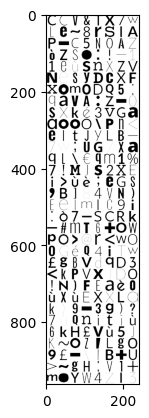

In [18]:
# get some random training images
dataiter = iter(trainloader)
images, labels, t, b = next(dataiter)

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('four_img-to-str_images', img_grid)

tensorboard --logdir=runs

In [19]:
writer.add_graph(net, (images, t, b))
writer.close()

In [20]:
# helper function
def select_n_random(data, labels, n=100):
    '''
    Selects n random datapoints and their corresponding labels from a dataset
    '''
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

# select random images and their target indices
images, labels = select_n_random(trainset.data, trainset.targets)
print("Images shape: ", images.shape)
print("Labels shape: ", labels.shape)

# get the class labels for each image
class_labels = [classes[lab] for lab in labels]

# log embeddings
features = images.view(-1, 28 * 28)
writer.add_embedding(features,
                    metadata=class_labels,
                    label_img=images)
writer.close()

Images shape:  torch.Size([100, 1, 28, 28])
Labels shape:  torch.Size([100])


In [21]:
# helper functions

def images_to_probs(net, images, top_margin, bottom_margin):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images, top_margin, bottom_margin)
    # convert output probabilities to predicted class

    output = output.cpu()

    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels, top_margin, bottom_margin):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images, top_margin, bottom_margin)
    # plot the images in the batch, along with predicted and true labels

    images = images.cpu()

    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

In [22]:
if torch.xpu.is_available():
    net = net.xpu()

In [23]:
class AverageValueMeter():
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.sum = 0
        self.num = 0
    
    def add(self, value, num):
        self.sum += value * num
        self.num += num
    
    def value(self):
        try:
            return self.sum / self.num
        except:
            return None

In [24]:
loss_meter = AverageValueMeter()
accuracy_meter = AverageValueMeter()

global_step = 0
epochs = 25

loader = {
    'train': trainloader,
    'test': testloader
}

In [25]:
for epoch in range(epochs):  # loop over the dataset multiple times
    print(f'Epoch {epoch + 1}')
    for mode in ["train", "test"]:
        loss_meter.reset()
        accuracy_meter.reset()
        for i, data in enumerate(loader[mode]):
            global_step += batch_size
            with torch.set_grad_enabled(mode == "train"):
                # get the inputs; data is a list of [inputs, labels]

                inputs, labels, t, b = data
                if torch.xpu.is_available():
                    inputs, labels, t, b = inputs.xpu(), labels.xpu(), t.xpu(), b.xpu()


                # forward + backward + optimize
                outputs = net(inputs, t, b)
                loss = criterion(outputs, labels)

                if mode == "train":
                    loss.backward()
                    optimizer.step()
                    optimizer.zero_grad()

                loss_meter.add(loss.item(), inputs.size(0))
                accuracy_meter.add(accuracy_score(labels.cpu(), outputs.cpu().max(1)[1]), inputs.size(0))

                if i % 10 == 9:
                    writer.add_scalar(f'loss/{mode}',
                                    loss_meter.value(),
                                    global_step)
                    writer.add_scalar(f'accuracy/{mode}',
                                    accuracy_meter.value(),
                                    global_step)

                # ...log a Matplotlib Figure showing the model's predictions on a
                # random mini-batch
        print(f'\t[{mode}]\tLoss: {loss_meter.value():.4f}, Accuracy: {accuracy_meter.value():.4f}')
    print('=============================================================')
    if mode == "test":
        writer.add_figure('predictions vs. actuals',
                        plot_classes_preds(net, inputs, labels, t, b),
                        global_step)

print('Finished Training')

Epoch 1
	[train]	Loss: 4.5591, Accuracy: 0.0140
	[test]	Loss: 4.5494, Accuracy: 0.0174
Epoch 2
	[train]	Loss: 4.5252, Accuracy: 0.0218
	[test]	Loss: 4.4712, Accuracy: 0.0238
Epoch 3
	[train]	Loss: 4.3411, Accuracy: 0.0383
	[test]	Loss: 4.0323, Accuracy: 0.0773
Epoch 4
	[train]	Loss: 3.4573, Accuracy: 0.1571
	[test]	Loss: 2.6368, Accuracy: 0.2929
Epoch 5
	[train]	Loss: 2.1879, Accuracy: 0.3810
	[test]	Loss: 1.7437, Accuracy: 0.4854
Epoch 6
	[train]	Loss: 1.6115, Accuracy: 0.5122
	[test]	Loss: 1.4266, Accuracy: 0.5622
Epoch 7
	[train]	Loss: 1.3575, Accuracy: 0.5746
	[test]	Loss: 1.2810, Accuracy: 0.5998
Epoch 8
	[train]	Loss: 1.2068, Accuracy: 0.6150
	[test]	Loss: 1.1597, Accuracy: 0.6348
Epoch 9
	[train]	Loss: 1.1110, Accuracy: 0.6411
	[test]	Loss: 1.0792, Accuracy: 0.6552
Epoch 10
	[train]	Loss: 1.0275, Accuracy: 0.6630
	[test]	Loss: 1.0289, Accuracy: 0.6702
Epoch 11
	[train]	Loss: 0.9686, Accuracy: 0.6799
	[test]	Loss: 0.9994, Accuracy: 0.6762
Epoch 12
	[train]	Loss: 0.9208, Accuracy:

In [26]:
torch.save(net.state_dict(), 'model_weights_v4_25-epochs-dropout.pth')

# Evaluation

In [2]:
sys.path.append('../core')
from main import process_image

In [10]:
words_dir = "../dataset/words_dataset"
words_dataset = np.loadtxt(f'{words_dir}/dataset.txt', dtype=str, delimiter='\t', comments=[])

In [6]:
len(words_dataset)

1500

In [29]:
results = []
for i, data in enumerate(words_dataset):
    img_path = f'{words_dir}/{data[0]}'
    print("Processing: ", img_path)
    print(data[1])
    img = Image.open(img_path)
    try:
        _, output = process_image(img)
        edit_distance = Levenshtein.distance(data[1], output)

        results.append({
            'path': img_path,
            'label': data[1],
            'output': output,
            'edit_distance': edit_distance
        })
        print(f'{output}\nEDIT DISTANCE: {edit_distance}\n')
    except Exception as e:
        print(f'Error: {e}')
        results.append({
            'path': img_path,
            'label': data[1],
            'output': None,
            'edit_distance': None,
            'error': e
        })

Processing:  ../dataset/words_dataset/Lato-Medium/2e50447b593857e282acc3a924_32221.png
.PD{Y8W€é$
. P D{Y8w€è$
EDIT DISTANCE: 4

Processing:  ../dataset/words_dataset/Lato-Medium/76774e634770415c666b_81035.png
vwNcGpA\fk
vw N cG pA\N
EDIT DISTANCE: 5

Processing:  ../dataset/words_dataset/Lato-Medium/577b32352bc3b9762b4437_74553.png
W{25+ùv+D7
w{2 5 + ùv+ D 7
EDIT DISTANCE: 6

Processing:  ../dataset/words_dataset/Lato-Medium/536c2e68504d41446d2c_78218.png
Sl.hPMADm,
Sl. h PMADm,
EDIT DISTANCE: 2

Processing:  ../dataset/words_dataset/Lato-Medium/61753a44245d375d7578_51301.png
au:D$]7]ux
a u: D$]7] ux
EDIT DISTANCE: 3

Processing:  ../dataset/words_dataset/Lato-Medium/4f3b513b704d29213577_91954.png
O;Q;pM)!5w
o;Q; pM)! 5w
EDIT DISTANCE: 3

Processing:  ../dataset/words_dataset/Lato-Medium/34524e47462b34652952_55796.png
4RNGF+4e)R
4 RN G F+4e) R
EDIT DISTANCE: 4

Processing:  ../dataset/words_dataset/Lato-Medium/75455034576f726c6cc3b9_42634.png
uEP4Worllù
u E P4Wo r l l ù
EDIT DISTANCE:

In [22]:
results[0]
edit_distances = [result['edit_distance'] for result in results]
mean = np.mean(edit_distances)
variance = np.var(edit_distances)
minimum = np.min(edit_distances)
maximum = np.max(edit_distances)

print(f"Mean: {mean}, Variance: {variance}, Min: {minimum}, Max: {maximum}")

Mean: 5.125930941096818, Variance: 21.25699177045091, Min: 0, Max: 41


In [24]:
max_edit_distance_objects = [result for result in results if result['edit_distance'] == maximum]
print(max_edit_distance_objects)

[{'path': '../dataset/words_dataset/Lato-Medium/665b445043212028254b_38924.png', 'label': 'f[DPC! (%K', 'output': 'f[DPC! (%K', 'edit_distance': 0}, {'path': '../dataset/words_dataset/Lato-Medium/28732b20754a6ec3b93676_90122.png', 'label': '(s+ uJnù6v', 'output': '(s+ uJnù6v', 'edit_distance': 0}, {'path': '../dataset/words_dataset/Lato-Medium/6637207a2854c2a3443e54_86314.png', 'label': 'f7 z(T£D>T', 'output': 'f7 z(T£D>T', 'edit_distance': 0}, {'path': '../dataset/words_dataset/Lato-Medium/24527032362044263246_41062.png', 'label': '$Rp26 D&2F', 'output': '$Rp26 D&2F', 'edit_distance': 0}, {'path': '../dataset/words_dataset/PTS55F/7e714e547d20e282ac32c2a326_40568.png', 'label': '~qNT} €2£&', 'output': '~qNT} €2£&', 'edit_distance': 0}, {'path': '../dataset/words_dataset/PTS55F/63516f6f726820614c66_24054.png', 'label': 'cQoorh aLf', 'output': 'cQoorh aLf', 'edit_distance': 0}, {'path': '../dataset/words_dataset/Courier Prime/363a67583969573c2026_88572.png', 'label': '6:gX9iW< &', 'outpu

In [30]:
# Filter and print objects containing errors
error_objects = [result for result in results if 'error' in result]
print("Objects with errors:")
for obj in error_objects:
    print(obj)

Objects with errors:
{'path': '../dataset/words_dataset/Lato-Light/5b613b2f686b6c545d3e_60919.png', 'label': '[a;/hklT]>', 'output': None, 'edit_distance': None, 'error': error("OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4211: error: (-215:Assertion failed) inv_scale_x > 0 in function 'resize'\n")}
{'path': '../dataset/words_dataset/Lato-Light/566c77c2a3316e26423832_97465.png', 'label': 'Vlw£1n&B82', 'output': None, 'edit_distance': None, 'error': error("OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4211: error: (-215:Assertion failed) inv_scale_x > 0 in function 'resize'\n")}
{'path': '../dataset/words_dataset/Lato-Light/566c5c732f556250583c_53287.png', 'label': 'Vl\\s/UbPX<', 'output': None, 'edit_distance': None, 'error': error("OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4211: error: (-215:Assertion failed) inv_scale_x > 0 in function 'resize'\n")}
{'path': '../dataset/words_dataset/Lato-Light/28453a766c273e2734c3b9_83263.png', 'label': "(E:vl'

In [31]:
len(error_objects)

23

In [35]:
correct_predictions_case = sum(1 for result in results if result['output'] and result['label'] == result['output'])
correct_predictions = sum(1 for result in results if result['output'] and result['label'].lower() == result['output'].lower())
correct_predictions_no_spaces = sum(
    1 for result in results 
    if result['output'] and result['label'].replace(" ", "").lower() == result['output'].replace(" ", "").lower()
)

accuracy_case = correct_predictions_case / len(results) * 100
accuracy = correct_predictions / len(results) * 100
accuracy_no_spaces = correct_predictions_no_spaces / len(results) * 100

print(f"Accuracy (case sensitive): {accuracy_case:.2f}%")
print(f"Accuracy (case insensitive): {accuracy:.2f}%")
print(f"Accuracy (case insensitive, no spaces inside): {accuracy_no_spaces:.2f}%")

Accuracy (case sensitive): 2.53%
Accuracy (case insensitive): 4.13%
Accuracy (case insensitive, no spaces inside): 45.87%


confusion matrix

In [ ]:
digit_dataset = np.loadtxt('../dataset/digit_dataset/test.txt', dtype=str, delimiter='\t', comments=[])
first_column = digit_dataset[:, 0]
unique_values, unique_indices = np.unique(first_column, return_index=True)
digit_dataset = digit_dataset[unique_indices]

ground_truth = []
results = []
classes += 'ERROR'

for i, data in enumerate(digit_dataset):
    img_path = f'../dataset/digit_dataset/{data[0]}'
    img = Image.open(img_path)
    label = data[1]
    try:
        _, output = process_image(img)
        if output is None or output not in classes:
            output = 'ERROR'
        print(f"[{i}/{len(digit_dataset)}][{data[0].split('/')[0]}]: {label} -> {output}")
    except Exception as e:
        print(f"[{i}/{len(digit_dataset)}][{data[0].split('/')[0]}]: {label} -> {e}")
        output = 'ERROR'
    
    ground_truth.append(label)
    results.append(output)

/home/kevin/Documents/uni/3anno/2_semestre/MACHINE LEARNING/project/university-ml-imgtostr/src/../core/ImageToStringClassifier.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feat

[0/1410][PTS55F]: ! -> !
[1/1410][PTS55F]: # -> #
[2/1410][PTS55F]: $ -> $
[3/1410][PTS55F]: % -> %
[4/1410][PTS55F]: & -> &
[5/1410][PTS55F]: ' -> '
[6/1410][PTS55F]: ( -> (
[7/1410][PTS55F]: ) -> )
[8/1410][PTS55F]: + -> +
[9/1410][PTS55F]: , -> ,
[10/1410][PTS55F]: - -> -
[11/1410][PTS55F]: 0 -> 'NoneType' object is not subscriptable
[12/1410][PTS55F]: 1 -> 1
[13/1410][PTS55F]: 2 -> 2
[14/1410][PTS55F]: 3 -> 3
[15/1410][PTS55F]: 4 -> 4
[16/1410][PTS55F]: 5 -> 5
[17/1410][PTS55F]: 6 -> 6
[18/1410][PTS55F]: 7 -> 7
[19/1410][PTS55F]: 8 -> 8
[20/1410][PTS55F]: 9 -> 9
[21/1410][PTS55F]: : -> :
[22/1410][PTS55F]: ; -> ;
[23/1410][PTS55F]: < -> <
[24/1410][PTS55F]: > -> >
[25/1410][PTS55F]: ? -> ?
[26/1410][PTS55F]: @ -> @
[27/1410][PTS55F]: A -> A
[28/1410][PTS55F]: B -> B
[29/1410][PTS55F]: C -> 'NoneType' object is not subscriptable
[30/1410][PTS55F]: D -> D
[31/1410][PTS55F]: E -> E
[32/1410][PTS55F]: F -> F
[33/1410][PTS55F]: G -> G
[34/1410][PTS55F]: H -> H
[35/1410][PTS55F]: I -> I


In [ ]:
cm = ConfusionMatrix(actual_vector=ground_truth, predict_vector=results)

cm.save_html("../docs/assets/confusion_matrix_report", color=(100, 150, 255))  # Blu chiaro